# Motional magnetic field energy shifts
Calculating energy shifts due to motional magnetic fields in interaction region.
## Imports

In [84]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import numpy as np
from scipy.linalg import eigh

from centrex_TlF_hamiltonian.states import (State, CoupledBasisState, UncoupledBasisState, generate_uncoupled_states_ground, 
                                            find_state_idx_from_state, find_closest_vector_idx, ElectronicState, find_exact_states, 
                                            reorder_evecs)
from centrex_TlF_hamiltonian.hamiltonian import generate_uncoupled_hamiltonian_X, generate_uncoupled_hamiltonian_X_function, XConstants
from centrex_TlF_hamiltonian.hamiltonian.utils import matrix_to_states

## 2nd order perturbation theory

In [231]:
# Define magnetic dipoles for each nucleus
mu1 = XConstants.μ_Tl
mu2 = XConstants.μ_F

# Define energy differences between states
delta_E_hk = (72.8+46.7)*1e3
delta_E_hf = (72.8-62.2)*1e3
delta_E_ki = (-46.7-69.5)*1e3
delta_E_kl = (-46.7-72.8)*1e3

delta_E_ej = (72.8+46.7)*1e3
delta_E_eg = (72.8-62.2)*1e3
delta_E_ji = (-46.7-69.5)*1e3
delta_E_jl = (-46.7-72.8)*1e3

# Functions to calculate energy shifts in 2nd order perturbation theory
delta_f_hk = lambda Bx: (mu1**2*(2/delta_E_hk + 1/delta_E_hf) - 0.5*mu2**2*(1/delta_E_ki + 1/delta_E_kl))*Bx**2
delta_f_ej = lambda Bx: (mu1**2*(2/delta_E_ej+ 1/delta_E_eg) - 0.5*mu2**2*(1/delta_E_ji + 1/delta_E_jl))*Bx**2

# Functions that calculate gradient of frequency shift
grad_delta_f_hk = lambda Bx: 2*(mu1**2*(2/delta_E_hk + 1/delta_E_hf) - 0.5*mu2**2*(1/delta_E_ki + 1/delta_E_kl))*Bx
grad_delta_f_ej = lambda Bx: 2*(mu1**2*(2/delta_E_ej+ 1/delta_E_eg) - 0.5*mu2**2*(1/delta_E_ji + 1/delta_E_jl))*Bx

Bx = 0.5e-3
print(f"df_hk/dBx at Bx={Bx}G is {grad_delta_f_hk(Bx)*1e3/1e6:.3E} mHz/μG")
print(f"df_ej/dBx at Bx={Bx}G is {grad_delta_f_ej(Bx)*1e3/1e6:.3E} mHz/μG")

df_hk/dBx at Bx=0.0005G is 2.050E-04 mHz/μG
df_ej/dBx at Bx=0.0005G is 2.050E-04 mHz/μG


In [234]:
delta_f_hk(0.5e-3)/1e-3

0.05124992652865167

## Diagonalizing Hamiltonian
We can also calculate the shifts in the energies of states by diagonalizing the Hamiltonian

Start by defining the X-state Hamiltonian

In [24]:
# Generate quantum numbers
QN_X_uc = generate_uncoupled_states_ground(range(0,6))

# Generate Hamiltonian as function of E and B
H_X_EB = generate_uncoupled_hamiltonian_X_function(generate_uncoupled_hamiltonian_X(QN_X_uc))

Define the states we're interested in

In [37]:
J1_ppp = 1*UncoupledBasisState(J=1, mJ=1, I1=1/2, m1=1/2, I2=1/2, m2=1/2,Omega=0, P=-1, electronic_state=ElectronicState.X)
J1_pmp = 1*UncoupledBasisState(J=1, mJ=1, I1=1/2, m1=-1/2, I2=1/2, m2=1/2,Omega=0, P=-1, electronic_state=ElectronicState.X)
J1_mmm = J1_ppp.time_reversed()
J1_mpm = J1_pmp.time_reversed()

Find the correct states at 30 kV/cm by repeatedly diagonalizing the Hamiltonian

In [239]:
Emin = 100
Emax = 30e3
B = np.array([0,0,-1e-6])

# Diagonalize the Hamiltonian at minimum electric field
H_min = H_X_EB(np.array([0,0,Emin]), B)
D, V_ref_0 = np.linalg.eigh(H_min)
V_ref = V_ref_0

# Find indices that correspond to each state
J1_ppp_i = find_closest_vector_idx(J1_ppp.state_vector(QN_X_uc),V_ref_0)
J1_pmp_i = find_closest_vector_idx(J1_pmp.state_vector(QN_X_uc),V_ref_0)
J1_mmm_i = find_closest_vector_idx(J1_mmm.state_vector(QN_X_uc),V_ref_0)
J1_mpm_i = find_closest_vector_idx(J1_mpm.state_vector(QN_X_uc),V_ref_0)

# Determine states at large electric field (stored in V_ref)
for Ez in np.linspace(Emin, Emax, 1000):
    H = H_X_EB(np.array([0,0,Ez]), B)
    D, V = np.linalg.eigh(H)
    _, V_ref = reorder_evecs(V, D, V_ref)

V_ref_diag = V_ref

    
# Find energies as function of Bx
Bmin = 0
Bmax = 50e-3

# Determine states at large electric field (stored in V_ref)
energies = np.empty((1000, len(QN_X_uc)), dtype = float)
Bxs = np.linspace(Bmin, Bmax, len(energies))
for i, Bx in enumerate(Bxs):
    H = H_X_EB(np.array([0,0,Emax]), B+np.array([Bx,0,0]))
    D, V = np.linalg.eigh(H)
    energies[i,:] = D

Plot the frequencies of the relevant transitions

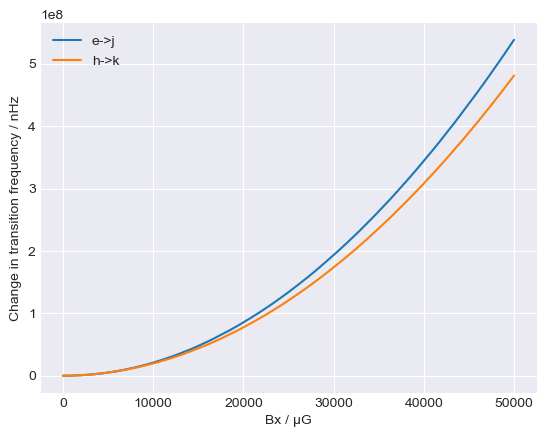

In [240]:
f_ej = (energies[:,J1_mmm_i] - energies[:,J1_mpm_i])/(2*np.pi)
f_hk = (energies[:,J1_ppp_i] - energies[:,J1_pmp_i])/(2*np.pi)

fig, ax = plt.subplots()
ax.plot(Bxs*1e6, (f_ej-f_ej[0])*1e9, label = 'e->j')
ax.plot(Bxs*1e6, (f_hk-f_hk[0])*1e9, label = 'h->k')
ax.set_xlabel('Bx / μG')
ax.set_ylabel('Change in transition frequency / nHz')
ax.legend()

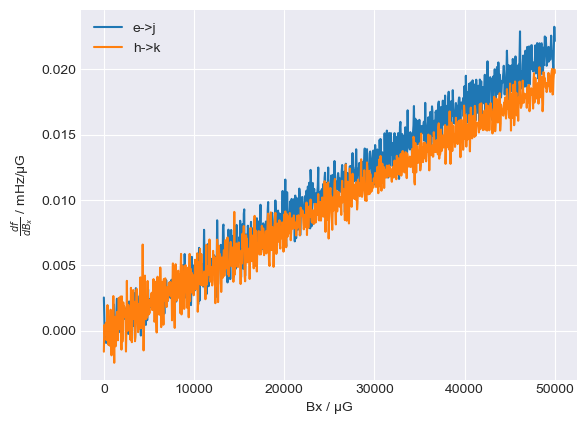

In [241]:
grad_f_ej = np.gradient(f_ej*1e3, Bxs*1e6) #mHz/muG
grad_f_hk = np.gradient(f_hk*1e3, Bxs*1e6)


fig, ax = plt.subplots()
ax.plot(Bxs*1e6, grad_f_ej, label = 'e->j')
ax.plot(Bxs*1e6, grad_f_hk, label = 'h->k')
ax.set_xlabel('Bx / μG')
ax.set_ylabel(r'$\frac{df}{dB_x}$ / mHz/μG')
ax.legend()

In [242]:
idx = np.argmax(-np.abs(Bxs-10e-6))
print(f"Gradient at Bx = 10μG: {grad_f_ej[idx]:.2E} mHz/μG")

Gradient at Bx = 10μG: 2.55E-03 mHz/μG


## Diagonalizing Hamiltonian - relevant submanifold only
We can also calculate the shifts in the energies of states by diagonalizing the Hamiltonian, but here I'm calculating the energy shifts due to the magnetic field inside the $J = 1, |m_J|=1$ submanifold only

Start by defining the X-state Hamiltonian

In [190]:
# Generate quantum numbers
QN_X_uc = generate_uncoupled_states_ground(range(0,6))

# Generate Hamiltonian as function of E and B
H_X_EB = generate_uncoupled_hamiltonian_X_function(generate_uncoupled_hamiltonian_X(QN_X_uc))

Define the states we're interested in

In [191]:
J1_ppp = 1*UncoupledBasisState(J=1, mJ=1, I1=1/2, m1=1/2, I2=1/2, m2=1/2,Omega=0, P=-1, electronic_state=ElectronicState.X)
J1_pmp = 1*UncoupledBasisState(J=1, mJ=1, I1=1/2, m1=-1/2, I2=1/2, m2=1/2,Omega=0, P=-1, electronic_state=ElectronicState.X)
J1_mmm = J1_ppp.time_reversed()
J1_mpm = J1_pmp.time_reversed()

Find the correct states at 30 kV/cm by repeatedly diagonalizing the Hamiltonian

In [235]:
Emin = 100
Emax = 30e3
B = np.array([0,0,-1e-6])

# Diagonalize the Hamiltonian at minimum electric field
H_min = H_X_EB(np.array([0,0,Emin]), B)
D, V_ref_0 = np.linalg.eigh(H_min)
V_ref = V_ref_0

# Find indices that correspond to each state
J1_ppp_i = find_closest_vector_idx(J1_ppp.state_vector(QN_X_uc),V_ref_0)
J1_pmp_i = find_closest_vector_idx(J1_pmp.state_vector(QN_X_uc),V_ref_0)
J1_mmm_i = find_closest_vector_idx(J1_mmm.state_vector(QN_X_uc),V_ref_0)
J1_mpm_i = find_closest_vector_idx(J1_mpm.state_vector(QN_X_uc),V_ref_0)

# Determine states at large electric field (stored in V_ref)
for Ez in np.linspace(Emin, Emax, 1000):
    H = H_X_EB(np.array([0,0,Ez]), B)
    D, V = np.linalg.eigh(H)
    _, V_ref = reorder_evecs(V, D, V_ref)

V_ref_diag = V_ref

# Diagonalize the Hamiltonian and convert to new basis
H_diag = V_ref.conj().T @ H @ V_ref
QN_diag = matrix_to_states(V_ref, QN_X_uc)
QN_sub = QN_diag[4:12]

# Pick out just the part that describes J =1, |m_J| = 1
H_sub = H_diag[4:12, 4:12]
H_sub = np.diag(np.diag(H_sub)-H_sub[0,0])

# Generate the Zeeman operator for the effective Hamiltonian
H_Bx = generate_uncoupled_hamiltonian_X(QN_X_uc).HZx*2*np.pi
H_Bx_sub =  (V_ref.conj().T @ H_Bx @ V_ref)[4:12,4:12]
    
# Find energies as function of Bx
Bmin = 0
Bmax = 50e-3

# Determine states at large electric field (stored in V_ref)
energies = np.empty((1000, 8), dtype = float)
Bxs = np.linspace(Bmin, Bmax, len(energies))
for i, Bx in enumerate(Bxs):
    H = H_sub + Bx*H_Bx_sub
    D, V = np.linalg.eigh(H)
    energies[i,:] = D

Plot the frequencies of the relevant transitions

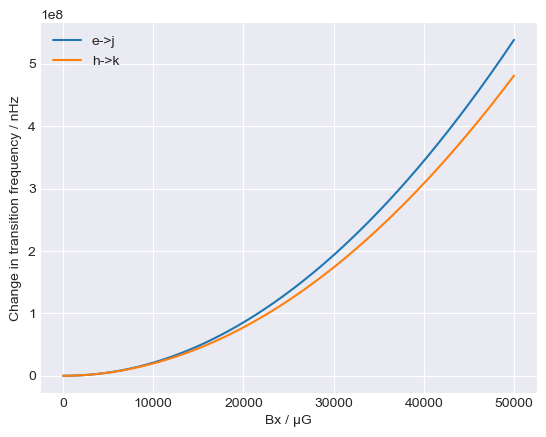

In [236]:
f_ej = (energies[:,J1_mmm_i-4] - energies[:,J1_mpm_i-4])/(2*np.pi)
f_hk = (energies[:,J1_ppp_i-4] - energies[:,J1_pmp_i-4])/(2*np.pi)

fig, ax = plt.subplots()
ax.plot(Bxs*1e6, (f_ej-f_ej[0])*1e9, label = 'e->j')
ax.plot(Bxs*1e6, (f_hk-f_hk[0])*1e9, label = 'h->k')
ax.set_xlabel('Bx / μG')
ax.set_ylabel('Change in transition frequency / nHz')
ax.legend()

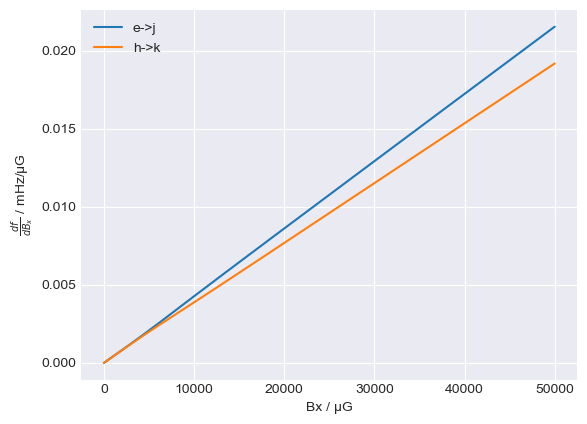

In [237]:
grad_f_ej = np.gradient(f_ej*1e3, Bxs*1e6) #mHz/muG
grad_f_hk = np.gradient(f_hk*1e3, Bxs*1e6)


fig, ax = plt.subplots()
ax.plot(Bxs*1e6, grad_f_ej, label = 'e->j')
ax.plot(Bxs*1e6, grad_f_hk, label = 'h->k')
ax.set_xlabel('Bx / μG')
ax.set_ylabel(r'$\frac{df}{dB_x}$ / mHz/μG')
ax.legend()

In [238]:
Bx_val = 70e-6
idx = np.argmax(-np.abs(Bxs-Bx_val))
print(f"Gradient for f_ej at Bx = {Bx_val*1e6:.1f} μG: {grad_f_ej[idx]:.2E} mHz/μG")
print(f"Gradient for f_hk at Bx = {Bx_val*1e6:.1f} μG: {grad_f_hk[idx]:.2E} mHz/μG")

Gradient for f_ej at Bx = 70.0 μG: 2.04E-05 mHz/μG
Gradient for f_hk at Bx = 70.0 μG: 2.04E-05 mHz/μG
